In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import MinMaxScaler



Load and plot data

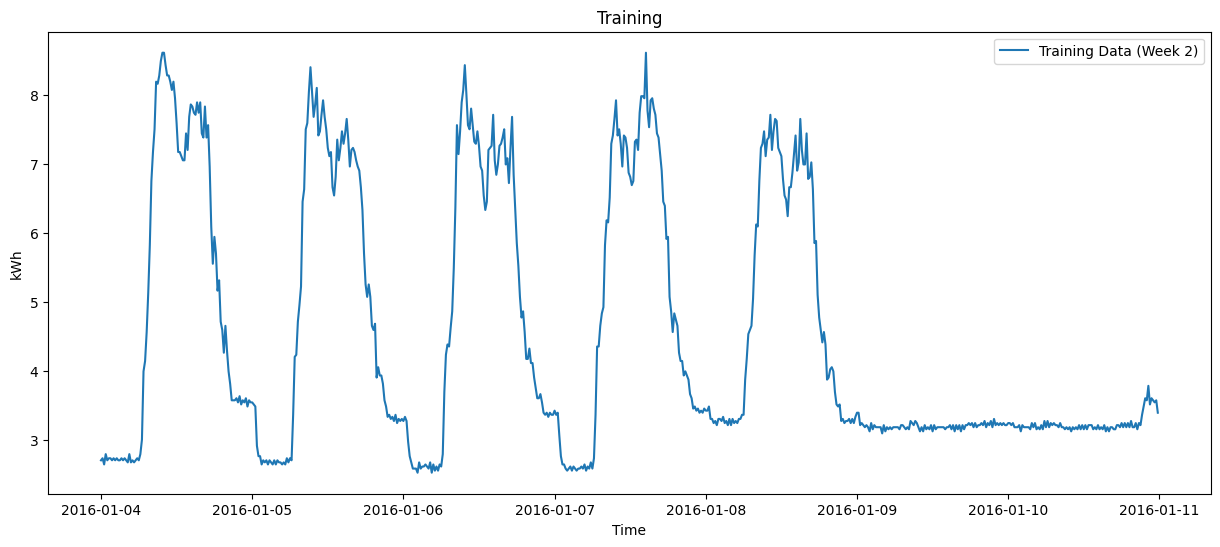

In [2]:

df = pd.read_csv('FinalData.csv')

df['datetime'] = pd.to_datetime(df['datetime'])

# gunakan data satu minggu pertama untuk data training
df_train = df[df['week'] == 1]

# plot data training
plt.figure(figsize=(15, 6))
plt.plot(df_train['datetime'], df_train['kWh'], label='Training Data (Week 2)')
plt.title('Training')
plt.xlabel('Time')
plt.ylabel('kWh')
plt.legend()
plt.show()


In [3]:
df_train

,datetime,kWh,date,weekday,workday,hour,week,continuous_hour
0,2016-01-04 00:00:00,2.70,2016-01-04,0,True,0,1,0
1,2016-01-04 00:15:00,2.73,2016-01-04,0,True,0,1,0
2,2016-01-04 00:30:00,2.64,2016-01-04,0,True,0,1,0
3,2016-01-04 00:45:00,2.79,2016-01-04,0,True,0,1,0
4,2016-01-04 01:00:00,2.70,2016-01-04,0,True,1,1,1
...,...,...,...,...,...,...,...,...
667,2016-01-10 22:45:00,3.60,2016-01-10,6,False,22,1,166
668,2016-01-10 23:00:00,3.57,2016-01-10,6,False,23,1,167
669,2016-01-10 23:15:00,3.54,2016-01-10,6,False,23,1,167
670,2016-01-10 23:30:00,3.57,2016-01-10,6,False,23,1,167


Membuat data anomali

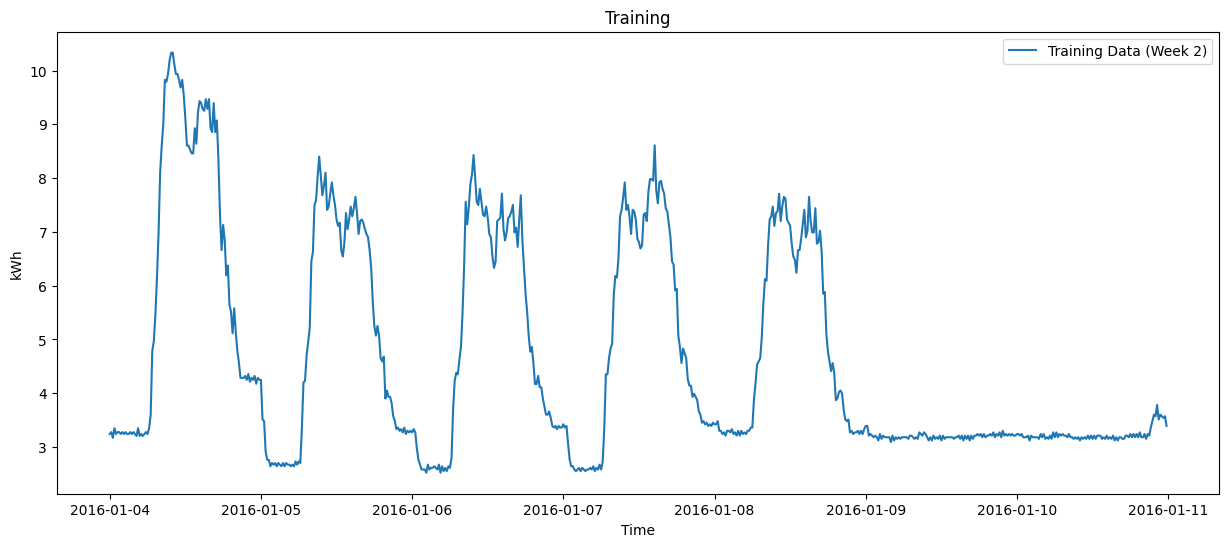

,datetime,kWh
667,2016-01-10 22:45:00,3.60
668,2016-01-10 23:00:00,3.57
669,2016-01-10 23:15:00,3.54
670,2016-01-10 23:30:00,3.57
671,2016-01-10 23:45:00,3.39


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

start_date = df['datetime'].min()
end_date = start_date + pd.Timedelta(days=7)
weekly_data = df[(df['datetime'] >= start_date) & (df['datetime'] < end_date)]

# nilai kWh hari pertama dikali 1.2
last_one_days_start = start_date + pd.Timedelta(days=1)
weekly_data.loc[weekly_data['datetime'] <= last_one_days_start, 'kWh'] *= 1.2
new_dataframe = weekly_data[['datetime', 'kWh']]
plt.figure(figsize=(15, 6))
plt.plot(new_dataframe['datetime'], new_dataframe['kWh'], label='Training Data (Week 2)')
plt.title('Training')
plt.xlabel('Time')
plt.ylabel('kWh')
plt.legend()
plt.show()
new_dataframe.tail()

Model Training

In [5]:
# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(df_train[['kWh']])
#with open('scaler.pkl', 'wb') as scaler_file:
    #pickle.dump(scaler, scaler_file)

# Prepare data for LSTM (reshape to [samples, timesteps, features])
timesteps = 1
X = []
for i in range(len(data_normalized) - timesteps):
    X.append(data_normalized[i:i+timesteps])
X = np.array(X)

# Split data into training and validation sets
train_size = int(len(X) * 0.9)
X_train = X[:train_size]
X_val = X[train_size:]

# Define LSTM Autoencoder
input_layer = Input(shape=(timesteps, 1))
encoder = LSTM(64, activation='relu', return_sequences=False)(input_layer)
decoder = RepeatVector(timesteps)(encoder)
decoder = LSTM(64, activation='relu', return_sequences=True)(decoder)
output_layer = TimeDistributed(Dense(1))(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val))

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1985 - val_loss: 0.0057
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1685 - val_loss: 5.3351e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1175 - val_loss: 0.0070
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0672 - val_loss: 0.0359
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0430 - val_loss: 0.0449
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0308 - val_loss: 0.0259
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212 - val_loss: 0.0173
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0091
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0041
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 4.6046e-04
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011

In [6]:
X_train.shape

(603, 1, 1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step


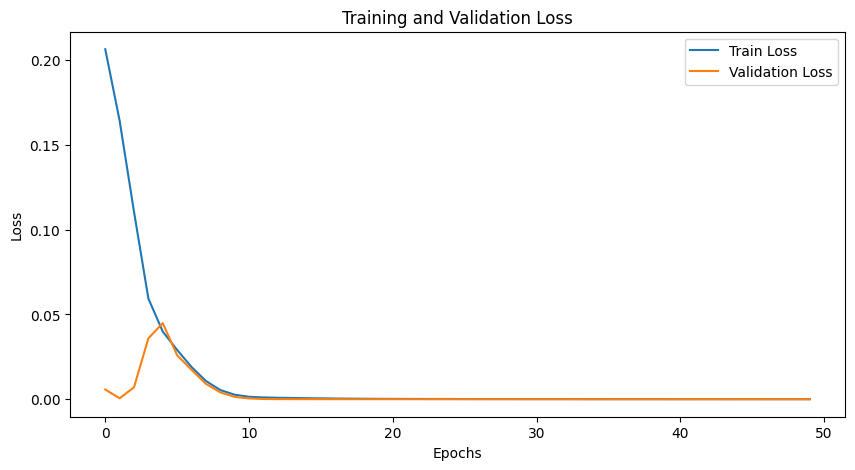

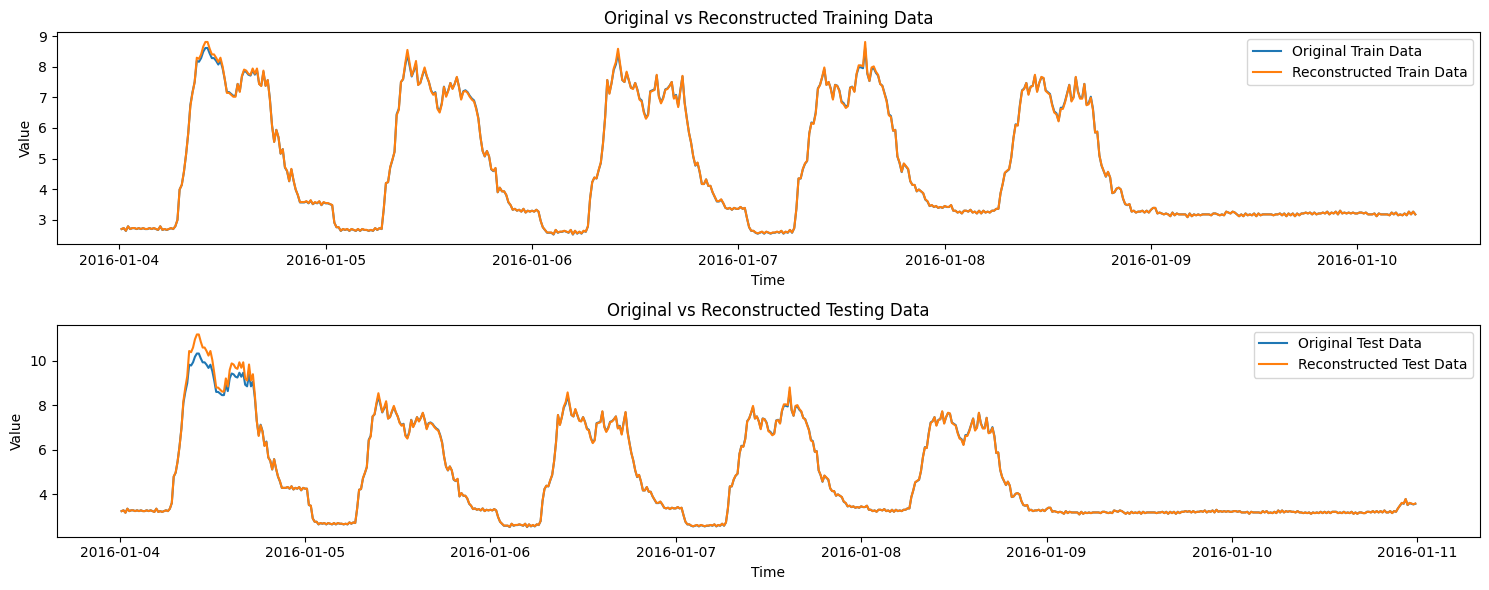

In [7]:
# Prepare anomalous data for LSTM (reshape to [samples, timesteps, features])
data_anomalous_normalized = scaler.transform(new_dataframe[['kWh']])
X_test = []
for i in range(len(data_anomalous_normalized) - timesteps):
    X_test.append(data_anomalous_normalized[i:i+timesteps])
X_test = np.array(X_test)

# Reconstruct the data
X_train_pred = autoencoder.predict(X_train)
X_val_pred = autoencoder.predict(X_val)
X_test_pred = autoencoder.predict(X_test)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize the reconstruction of train and test data
plt.figure(figsize=(15, 6))

# Original vs Reconstructed Training Data
plt.subplot(2, 1, 1)
plt.plot(df_train['datetime'][timesteps:train_size+timesteps], scaler.inverse_transform(X_train.reshape(-1, 1)[:train_size]), label='Original Train Data')
plt.plot(df_train['datetime'][timesteps:train_size+timesteps], scaler.inverse_transform(X_train_pred.reshape(-1, 1)[:train_size]), label='Reconstructed Train Data')
plt.title('Original vs Reconstructed Training Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Original vs Reconstructed Testing Data
plt.subplot(2, 1, 2)
plt.plot(new_dataframe['datetime'][timesteps:len(X_test)+timesteps], scaler.inverse_transform(X_test.reshape(-1, 1)[:len(X_test)]), label='Original Test Data')
plt.plot(new_dataframe['datetime'][timesteps:len(X_test)+timesteps], scaler.inverse_transform(X_test_pred.reshape(-1, 1)[:len(X_test)]), label='Reconstructed Test Data')
plt.title('Original vs Reconstructed Testing Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
X_test.shape

(671, 1, 1)

In [9]:
train_reconstruction_error = np.mean(np.abs(X_train_pred - X_train), axis=(1, 2))
val_reconstruction_error = np.mean(np.abs(X_val_pred - X_val), axis=(1, 2))
test_reconstruction_error = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))

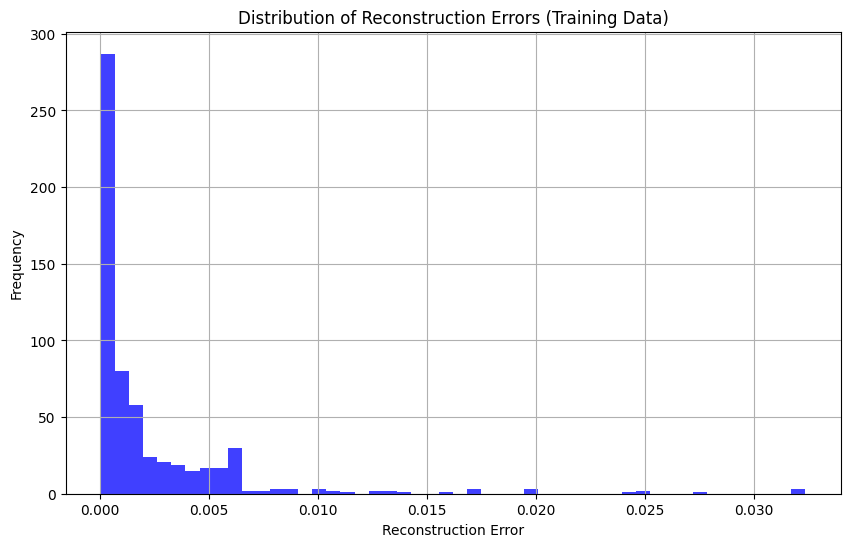

In [10]:
# Plot the distribution of the reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(train_reconstruction_error, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Reconstruction Errors (Training Data)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [11]:
train_reconstruction_error.max()

0.03234362602233887

set threshold di atas train reconstruction error sedikit

In [14]:
threshold = 0.033

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step


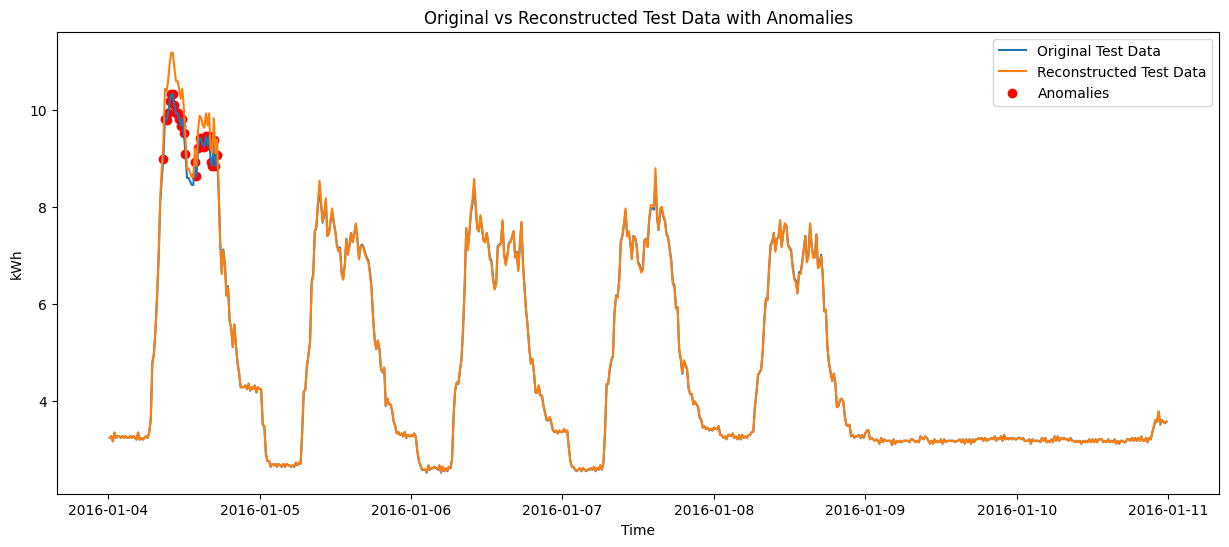

In [15]:
# Reconstruct the test data
X_test_pred = autoencoder.predict(X_test)

# Calculate the reconstruction error for the test data
test_reconstruction_error = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))

# Identify anomalies in the test data
anomalies = test_reconstruction_error > threshold

# Visualize the test data and highlight anomalies
plt.figure(figsize=(15, 6))
plt.plot(new_dataframe['datetime'][timesteps:], scaler.inverse_transform(X_test.reshape(-1, 1)), label='Original Test Data')
plt.plot(new_dataframe['datetime'][timesteps:], scaler.inverse_transform(X_test_pred.reshape(-1, 1)), label='Reconstructed Test Data')

# Highlight anomalies
anomaly_timestamps = new_dataframe['datetime'][timesteps:][anomalies]
anomaly_values = scaler.inverse_transform(X_test.reshape(-1, 1))[anomalies]
plt.scatter(anomaly_timestamps, anomaly_values, color='red', label='Anomalies')

plt.title('Original vs Reconstructed Test Data with Anomalies')
plt.xlabel('Time')
plt.ylabel('kWh')
plt.legend()
plt.show()

In [16]:
anomaly_indices = np.where(anomalies)[0]
anomaly_datetimes = new_dataframe.iloc[anomaly_indices]['datetime']
anomaly_kWh = new_dataframe.iloc[anomaly_indices]['kWh']
# Print anomaly datetimes
print(anomaly_datetimes)

34   2016-01-04 08:30:00
35   2016-01-04 08:45:00
36   2016-01-04 09:00:00
37   2016-01-04 09:15:00
38   2016-01-04 09:30:00
39   2016-01-04 09:45:00
40   2016-01-04 10:00:00
41   2016-01-04 10:15:00
42   2016-01-04 10:30:00
43   2016-01-04 10:45:00
44   2016-01-04 11:00:00
45   2016-01-04 11:15:00
46   2016-01-04 11:30:00
47   2016-01-04 11:45:00
48   2016-01-04 12:00:00
54   2016-01-04 13:30:00
55   2016-01-04 13:45:00
56   2016-01-04 14:00:00
57   2016-01-04 14:15:00
58   2016-01-04 14:30:00
59   2016-01-04 14:45:00
60   2016-01-04 15:00:00
61   2016-01-04 15:15:00
62   2016-01-04 15:30:00
63   2016-01-04 15:45:00
64   2016-01-04 16:00:00
65   2016-01-04 16:15:00
66   2016-01-04 16:30:00
67   2016-01-04 16:45:00
68   2016-01-04 17:00:00
Name: datetime, dtype: datetime64[ns]


In [17]:

#with open('lstm_autoencoder_model_V1.pkl', 'wb') as file:
    #pickle.dump(autoencoder, file)